# SVM with polynomial kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* degree (default=3)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Polynomial kernel function:  $(\gamma \langle x, x'\rangle + r)^d$. d is specified by keyword degree, r by coef0.

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '1243', '11234']
dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 3030
Testing set length for 10795: 1010
Cross-validation set length for 10795: 1010
Training set length for 12098: 3030
Testing set length for 12098: 1010
Cross-validation set length for 12098: 1010
Training set length for 11618: 3030
Testing set length for 11618: 1010
Cross-validation set length for 11618: 1010
Training set length for 1243: 3030
Testing set length for 1243: 1010
Cross-validation set length for 1243: 1010
Training set length for 11234: 3030
Testing set length for 11234: 1010
Cross-validation set length for 11234: 1010


In [3]:
dfs[stocks[0]].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-10 09:34:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1525.0, 1410.0), (1526.0, 3511.0), (1527.0, ...",1523.0,1525.0,1524.0,1410.0,1032.0,1.0,-0.154791
1011,2013-09-10 09:35:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 3811.0), (1527.0, 3759.0), (1528.0, ...",1523.0,1526.0,1524.5,3811.0,3889.0,1.0,0.010130
1012,2013-09-10 09:36:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 476.0), (1527.0, 3703.0), (1528.0, 6...",1525.0,1526.0,1525.5,476.0,757.0,1.0,0.227899
1013,2013-09-10 09:37:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1527.0, 419.0), (1528.0, 3608.0), (1529.0, 3...",1525.0,1527.0,1526.0,419.0,3116.0,0.0,0.762942
1014,2013-09-10 09:41:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1524.0, 1781.0), (1525.0, 11186.0), (1526.0,...",1523.0,1524.0,1523.5,1781.0,1207.0,1.0,-0.192102


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

### Degree

We can easily see that polynomials with even degree don't make any sense (because we didn't normalize feature queue imbalance - it shouldn't be negative for even degree polynomial kernels to work). It seems that the best polynomial is the polynomial with degree = 1 surprisingly. 

For the later tests we will take $degree = 3$, because $degree=1$ we test in notebook with **linear** kernel.

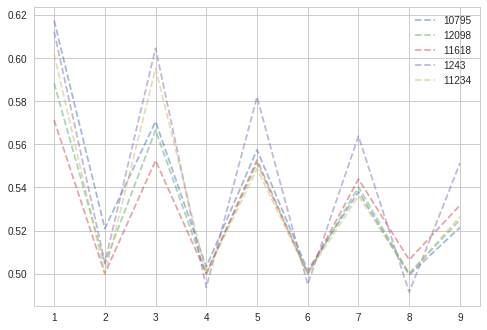

In [5]:
degrees = np.array(range(1, 10))

df_degs = {}

for s in stocks:
    df_deg = pd.DataFrame(index=degrees)
    df_deg['roc'] = np.zeros(len(df_deg))
    for c in degrees:
        reg_svm = svm_classification(dfs[s], 'poly', degree=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_deg.loc[c] = logit_roc_auc
    plt.plot(df_deg, linestyle='--', label=s, marker='x', alpha=0.5)
    df_degs[s] = df_deg
plt.legend()

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

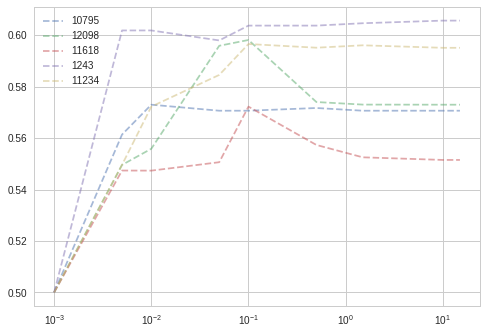

In [6]:
cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.5, 10, 15]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'poly', C=c, degree=3)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small (less than 0.5) for most of the stocks except **10795**.

In [7]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.01
For 12098 the best is 0.1
For 11618 the best is 0.1
For 1243 the best is 10.0
For 11234 the best is 0.1


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For two stocks **12098** and **11618** it can affect the prediction by 0.1, for the rest the difference is less.

In [8]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.07296606000983763
For 12098 the diff between best and worst 0.09811709326272422
For 11618 the diff between best and worst 0.0722156862745098
For 1243 the diff between best and worst 0.10564705882352943
For 11234 the diff between best and worst 0.09654800431499466


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

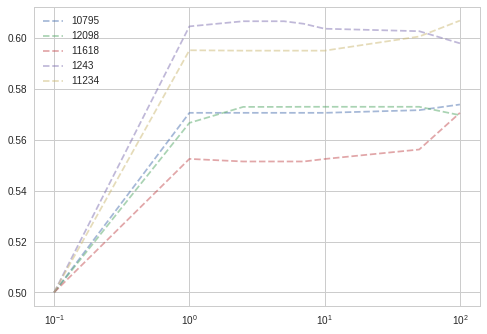

In [9]:
gammas = [0.1, 1, 2.5, 5, 7, 10, 50, 100]

df_gammas = {}
ax = plt.subplot()
ax.set_xscale("log", basex=10)

for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'poly', gamma=g, degree=3)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter - for stock **10795** and **2051** the value is very large, for the rest it is 1 or 2.

In [10]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 100.0
For 12098 the best is 7.0
For 11618 the best is 100.0
For 1243 the best is 2.5
For 11234 the best is 100.0


##### Influence of gamma

In [ ]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.07390063944908998
For 12098 the diff between best and worst 0.07300186329312541
For 11618 the diff between best and worst 0.07062745098039214
For 1243 the diff between best and worst 0.10664705882352943
For 11234 the diff between best and worst 0.1068941845640875


### Coef0

For polynomial kernel we use function: $(\gamma \langle x, x'\rangle + r)^d$ where d is specified by keyword degree, r by coef0.

In [ ]:
coeffs = [0.0001, 0.01, 0.1, 1, 10, 100]

df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=coeffs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        reg_svm = svm_classification(dfs[s], 'poly', coef0=c, degree=3)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

For **2051** and **4481** the coef0 value should be rather big (around 100), for the rest small.

In [ ]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

##### Influence of coef0

Choice of coef0 does not seem to have big significancy.

In [ ]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

# Results

We compare reults of SVMs with the best choices of each parameter against the logistic regression and SVM with defaults. We use only naive approach - each parameter is chosen separately.

In [ ]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(
        dfs[s], 'poly', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax(),
        coef0=df_coefs[s]['roc'].idxmax(), degree=3)
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'poly')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [ ]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0', 'degree')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax(), '\t', 3)

# Conclusions

The polynomial kernel for parameters we tried gives a bit worse results for every stock than logistic regression. It's also computionally heavy.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>